## Imports: Some may be redundant and could probably be cleaned up

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import scipy
import scipy.ndimage as ndimage
from PIL import Image
import math
import timeit
from fractions import gcd
import os
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

## Full Process to get a slice, given a template and three points that form the desired plane. Might eventually make it so that it can take angles and a single point instead, if that would be more helpful.

In [121]:
def get_slice_image(template, point_1, point_2, point_3):
    plane_eq = get_plane_equation(point_1, point_2, point_3)
    index_array = make_index_array(tv, plane_eq)
    skew_to = find_skew_coords(index_array)
    section = ndimage.map_coordinates(tv, index_array)
    src = ((0,0), (section.shape[0], 0), (0, section.shape[1]), (section.shape[0], section.shape[1]))
    coeffs = find_coeffs(skew_to, src)
    
    # need to save the image momentarily to perform the perspective transform on it
    scipy.misc.imsave('temp_img.png', section.transpose())
    img = Image.open('temp_img.png')
    
    new_width = max(skew_to[0][0], skew_to[1][0], skew_to[2][0], skew_to[3][0])
    new_height = max(skew_to[0][1], skew_to[1][1], skew_to[2][1], skew_to[3][1])
    
    new_img = img.transform((new_width, new_height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)
    
    image_array = np.asarray(img)
    new_image_array = np.asarray(new_img)
        
    ### Below this is just to show the images ###
    
    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(1, 2, width_ratios=[image_array.shape[0], new_image_array.shape[0]]) 

    ax1 = fig.add_subplot(gs[0])
    ax1.title.set_text('Non-Skewed Image')
    plt.imshow(image_array, cmap=plt.cm.gray)
    
    ax2 = fig.add_subplot(gs[1])
    ax2.title.set_text('Corrected Skewed Image')
    plt.imshow(new_image_array, cmap=plt.cm.gray)
    
    # deletes the temp image
    os.remove('temp_img.png')
    
    return image_array, new_image_array


## From the three points, get the equation of the resulting plane

In [122]:
def get_plane_equation(point_1, point_2, point_3):
    line_12 = point_2 - point_1
    line_13 = point_3 - point_1

    cross_product = np.cross(line_12, line_13)

    norm_vect = cross_product / gcd(cross_product[0],(gcd(cross_product[1],cross_product[2])))

    a, b, c = norm_vect[0], norm_vect[1], norm_vect[2]
    d = norm_vect[0] * point_1[0] + norm_vect[1] * point_1[1] + norm_vect[2] * point_1[2]

    print a, "x + ", b, "y + ", c, "z = ", d
    
    return np.array([a, b, c, d])

## Make the index array from the plane equation

In [123]:
def make_index_array(template, plane_eq):
    a, b, c, d = plane_eq[0], plane_eq[1], plane_eq[2], plane_eq[3]
    
    if abs(c) < abs(a) and abs(c) < abs(b) or c == 0:
        if abs(a) < abs(b) or a == 0: # b != 0
            indexes = np.zeros((3, template.shape[0], template.shape[2]))
            for i in range(template.shape[0]):
                for j in range(template.shape[2]):
                    indexes[0, i, j] = i
                    indexes[2, i, j] = j
                    indexes[1, i, j] = (float(d) - (i * a + j * c)) / b

        else: # a != 0
            indexes = np.zeros((3, template.shape[1], template.shape[2]))
            for i in range(template.shape[1]):
                for j in range(template.shape[2]):
                    indexes[1, i, j] = i
                    indexes[2, i, j] = j
                    indexes[0, i, j] = (float(d) - (i * b + j * c)) / a

    else: # c != 0
        indexes = np.zeros((3, template.shape[0], template.shape[1]))
        for i in range(template.shape[0]):
            for j in range(template.shape[1]):
                indexes[0, i, j] = i
                indexes[1, i, j] = j
                indexes[2, i, j] = (float(d) - (i * a + j * b)) / c

    return indexes

## Find the coordinates to skew the template to after mapping coordinates so that the resulting image looks like it's seen head on

In [124]:
def find_skew_coords(indexes):
    point_0_3d = np.array([indexes[0, 0, 0], indexes[1, 0, 0], indexes[2, 0, 0]])
    point_1_3d = np.array([indexes[0, indexes.shape[1] - 1, 0], indexes[1, indexes.shape[1] - 1, 0], indexes[2, indexes.shape[1] - 1, 0]])
    point_2_3d = np.array([indexes[0, 0, indexes.shape[2] - 1], indexes[1, 0, indexes.shape[2] - 1], indexes[2, 0, indexes.shape[2] - 1]])
    point_3_3d = np.array([indexes[0, indexes.shape[1] - 1, indexes.shape[2] - 1], indexes[1, indexes.shape[1] - 1, indexes.shape[2] - 1], indexes[2, indexes.shape[1] - 1, indexes.shape[2] - 1]])
    
    side_a = np.linalg.norm(point_1_3d - point_0_3d)
    side_b = np.linalg.norm(point_2_3d - point_0_3d)
    side_c = np.linalg.norm(point_3_3d - point_2_3d)
    side_d = np.linalg.norm(point_3_3d - point_1_3d)
    diag_1 = np.linalg.norm(point_3_3d - point_0_3d)
    diag_2 = np.linalg.norm(point_2_3d - point_1_3d)
    
    angle_1 = math.acos(float(diag_2**2 - (side_a**2 + side_b**2)) / (-2 * side_a * side_b))
    angle_2 = math.acos(float(side_d**2 - (side_a**2 + diag_1**2)) / (-2 * side_a * diag_1))
    
    point_0 = (0, 0)
    point_1 = (int(round(side_a)), 0)
    point_2 = (int(round(np.cos(angle_1) * side_b)), int(round(np.sin(angle_1) * side_b)))
    point_3 = (int(round(np.cos(angle_2) * diag_1)), int(round(np.sin(angle_2) * diag_1)))
    
    skew_neg_x = abs(min(point_0[0], point_1[0], point_2[0], point_3[0]))
    skew_neg_y = abs(min(point_0[0], point_1[1], point_2[1], point_3[1]))
    
    point_0_pos = (point_0[0] + skew_neg_x, point_0[1] + skew_neg_y)
    point_1_pos = (point_1[0] + skew_neg_x, point_1[1] + skew_neg_y)
    point_2_pos = (point_2[0] + skew_neg_x, point_2[1] + skew_neg_y)
    point_3_pos = (point_3[0] + skew_neg_x, point_3[1] + skew_neg_y)
    
    skew_to = (point_0_pos, point_1_pos, point_2_pos, point_3_pos)
    
    return skew_to

## Someone's code I found online that will take two pairs of four coordinates to find the perspective transform matrix

In [125]:
def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = np.matrix(matrix, dtype=np.float)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

# Example script to run all these things

In [126]:
mcc = MouseConnectivityCache(manifest_file='mcc/manifest.json', resolution=25)

In [127]:
av, _ = mcc.get_annotation_volume()
av.shape

(528L, 320L, 456L)

In [128]:
tv, _ = mcc.get_template_volume()
tv.shape

(528L, 320L, 456L)

## Starting timer from here seemed reasonable

In [137]:
start_time = timeit.default_timer()

## Some points I was testing this on

In [138]:
point_1 = np.array([0, 150, 0])
point_2 = np.array([528, 160, 456])
point_3 = np.array([280, 350, 200])

# point_1 = np.array([0, 160, 0])
# point_2 = np.array([528, 160, 456])
# point_3 = np.array([280, 160, 200])

# point_1 = np.array([0, 0, 0])
# point_2 = np.array([tv.shape[0], tv.shape[1], 0])
# point_3 = np.array([tv.shape[0], tv.shape[1], tv.shape[2]])

# point_1 = np.array([0, 0, 0])
# point_2 = np.array([1, 1, 0])
# point_3 = np.array([1, 1, 1])

# point_1 = np.array([0, 100, 0])
# point_2 = np.array([264, 160, 0])
# point_3 = np.array([527, 220, 228])

# point_1 = np.array([0, 200, 0])
# point_2 = np.array([200, 0, 0])
# point_3 = np.array([200, 200, 200])

# point_1 = np.array([0, 0, 0])
# point_2 = np.array([499, 499, 499])
# point_3 = np.array([499, 0, 250])

# One call is all you need for it to display the equation of the plane and two resulting images. The images look alright I think, but it's kinda hard to tell

-1115 x +  276 y +  1285 z =  41400


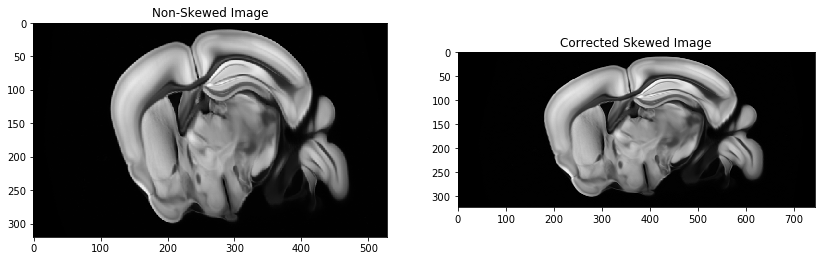

In [139]:
image_array, new_image_array = get_slice_image(tv, point_1, point_2, point_3)

## Usually between 3 and 4 seconds - not bad...

In [140]:
elapsed = timeit.default_timer() - start_time
print str(elapsed) + ' seconds'

3.24318880956 seconds
